In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [13]:
# Cell 2: Load and Preprocess Data (Updated for Cross-Validation)
# Load the dataset (replace 'diabetes.csv' with your file path if needed)
df = pd.read_csv('diabetes.csv')  # Download from Kaggle: https://www.kaggle.com/uciml/pima-indians-diabetes-database

# Brief description: This is a tabular dataset with 768 samples, 8 features (e.g., Glucose, BMI), and a binary target (Outcome: 0/1 for diabetes).

# Preprocessing: Handle missing values (replace 0s in certain columns with mean), normalize features
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)
df.fillna(df.mean(), inplace=True)

# Separate features (X) and target (y)
X = df.drop('Outcome', axis=1).values  # 8 features
y = df['Outcome'].values  # Binary target

# Normalize features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set up 5-fold cross-validation (KFold)
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV for robust evaluation

# Note: We don't split here; the CV loop in the next cell will handle train/val/test splits per fold.
print("Data loaded and preprocessed for cross-validation. Ready for training.")

Data loaded and preprocessed for cross-validation. Ready for training.


In [14]:
# Define a simple feedforward neural network (3 layers: input -> hidden -> hidden -> output)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(8, 64)  # Input layer: 8 features -> 64 neurons
        self.fc2 = nn.Linear(64, 32)  # Hidden layer: 64 -> 32 neurons
        self.fc3 = nn.Linear(32, 1)   # Output layer: 32 -> 1 neuron (for binary classification)
        self.sigmoid = nn.Sigmoid()   # Sigmoid for probability output (0-1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for hidden layers
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  # Sigmoid for final output
        return x

# Instantiate the model
model = SimpleNN()
print("Model architecture defined.")
# Justification: A simple NN is appropriate for tabular data like this. No pre-trained models used to keep it basic and original.

Model architecture defined.



Fold 1/5
Early stopping at epoch 20 for fold 1
Fold 1 Metrics - Acc: 0.7597, Prec: 0.6800, Rec: 0.6182, F1: 0.6476, AUC: 0.7283

Fold 2/5
Early stopping at epoch 18 for fold 2
Fold 2 Metrics - Acc: 0.7857, Prec: 0.6458, Rec: 0.6596, F1: 0.6526, AUC: 0.7503

Fold 3/5
Early stopping at epoch 15 for fold 3
Fold 3 Metrics - Acc: 0.7597, Prec: 0.7857, Rec: 0.5410, F1: 0.6408, AUC: 0.7221

Fold 4/5
Early stopping at epoch 17 for fold 4
Fold 4 Metrics - Acc: 0.7712, Prec: 0.6765, Rec: 0.4894, F1: 0.5679, AUC: 0.6928

Fold 5/5
Early stopping at epoch 14 for fold 5
Fold 5 Metrics - Acc: 0.7582, Prec: 0.7561, Rec: 0.5345, F1: 0.6263, AUC: 0.7146

Average CV Metrics - Acc: 0.7669, Prec: 0.7088, Rec: 0.5685, F1: 0.6270, AUC: 0.7216


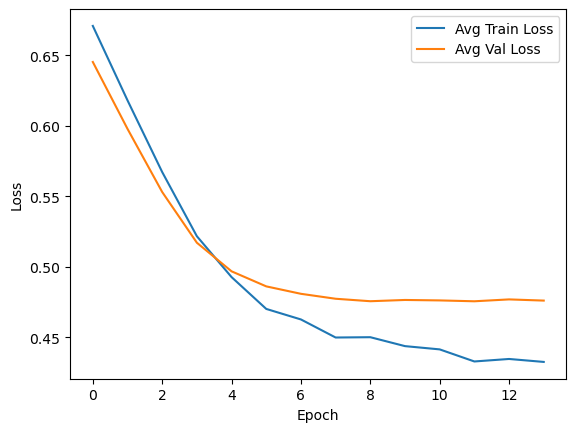

In [17]:
# Replace all of Cell 4 and Cell 5 with this (new combined cell for CV)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# CV variables
all_train_losses = []
all_val_losses = []
fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

for fold, (train_val_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold+1}/5")
    
    # Split data for this fold
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    
    # Further split train_val into train and val (80/20)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
    
    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    # DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # Reinitialize model, optimizer, and criterion for each fold
    model = SimpleNN()  # From Cell 3
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # L2 regularization
    criterion = nn.BCELoss()
    
    # Early stopping variables (already in your snippet)
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    
    train_losses = []
    val_losses = []
    
    # Training loop (with early stopping and L1/L2)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # Optional L1: loss += l1_lambda * sum(p.abs().sum() for p in model.parameters())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        # Early stopping check
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1} for fold {fold+1}")
                break
    
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    
    # Evaluation for this fold
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            preds = (outputs > 0.5).float()
            y_pred.extend(preds.numpy().flatten())
            y_true.extend(y_batch.numpy().flatten())
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    fold_metrics['accuracy'].append(accuracy)
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(f1)
    fold_metrics['auc'].append(auc)
    
    print(f"Fold {fold+1} Metrics - Acc: {accuracy:.4f}, Prec: {precision:.4f}, Rec: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# Average metrics across folds
avg_metrics = {k: np.mean(v) for k, v in fold_metrics.items()}
print(f"\nAverage CV Metrics - Acc: {avg_metrics['accuracy']:.4f}, Prec: {avg_metrics['precision']:.4f}, Rec: {avg_metrics['recall']:.4f}, F1: {avg_metrics['f1']:.4f}, AUC: {avg_metrics['auc']:.4f}")

# Plot average loss curves
avg_train_losses = np.mean([losses + [np.nan] * (max(len(l) for l in all_train_losses) - len(losses)) for losses in all_train_losses], axis=0)
avg_val_losses = np.mean([losses + [np.nan] * (max(len(l) for l in all_val_losses) - len(losses)) for losses in all_val_losses], axis=0)
plt.plot(avg_train_losses, label='Avg Train Loss')
plt.plot(avg_val_losses, label='Avg Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()